In [10]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from time import localtime, strftime, strptime
import os
from D2.data_selector import DataSelector

SEED = 42

In [ ]:
ds = DataSelector("../D2/data.csv")
data = ds.select_data(30000, length=5, scale_sd=1.5, seed=SEED)
data['conversation'] = data['conversation'].astype(str)

/home/alexlu/Documents/Programming/alexlu07/Scires/11th/VAD/M1.5/../D2/data_selector.py:10: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(filepath)


Filtering...
Calculating counts...
Grabbing data...


In [ ]:
raw_dataset = Dataset.from_pandas(data)
train_testval = raw_dataset.train_test_split(test_size=0.2, seed=SEED)
test_val = train_testval['test'].train_test_split(test_size=0.5, seed=SEED)

dataset = DatasetDict({
    'train': train_testval['train'],
    'test': test_val['test'],
    'val': test_val['train']}
)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def mask_data(mask_ratio):
    def mask_function(examples):
        mask_idx = np.random.choice(len(examples), int(mask_ratio * len(examples)), replace=False)
        convs = examples["text"]
        for i in mask_idx:
            convs[i][-1] = tokenizer.mask_token
        
        return {"text": convs}

    return mask_function

def preprocess_data(examples):
    role_names = ("speaker", "respondent")

    convs = [
        tokenizer.apply_chat_template(
            [{"role": role_names[i % 2], "content": x} for i, x in enumerate(m)], 
            tokenize=False)
        for m in examples["text"]
    ]

    encoding = tokenizer(convs, max_length=512, truncation=True)
    encoding["labels"] = list(zip(examples["V"], examples["A"], examples["D"]))

    return encoding

test_dataset = dataset["test"].map(mask_data(0), batched=True, batch_size=100000)
test_dataset = test_dataset.map(preprocess_data, batched=True, batch_size=100000)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]


No chat template is defined for this tokenizer - using a default chat template that implements the ChatML format (without BOS/EOS tokens!). If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
def get_checkpoint(epoch=0, run="latest", folder_path="results"):
    if run == "latest":
        run = max(os.listdir(folder_path), key=lambda x: strptime(x, "%b-%d-%y-%H:%M:%S"))

    checkpoint = sorted(os.listdir(f"{folder_path}/{run}"), key=lambda x: int(x.split("-")[1]))[epoch-1]

    return f"{folder_path}/{run}/{checkpoint}"

c = get_checkpoint(10)
model = AutoModelForSequenceClassification.from_pretrained(c)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = 4/(1+np.exp(-logits)) + 1

    metrics = {
        "mae": mean_absolute_error(labels, logits, multioutput="raw_values").tolist(),
        "mse": mean_squared_error(labels, logits, multioutput="raw_values").tolist(),
        "pearsonr": [pearsonr(logits[:, i], labels[:, i])[0] for i in range(len(logits[0]))],
        "r_squared": r2_score(labels, logits, multioutput="raw_values").tolist(),
    }

    return {f"{m}_{s}": metrics[m][i] for i, s in enumerate("VAD") for m in metrics}

In [ ]:
class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = torch.sigmoid(outputs['logits']) * 4 + 1
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [47]:
training_args = TrainingArguments(
    output_dir="/tmp/tmp_trainer",
    per_device_eval_batch_size=32,
    report_to="none",
)

trainer = RegressionTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [48]:
trainer.evaluate(test_dataset)

  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.0439121350646019,
 'eval_mae_V': 0.15871267020702362,
 'eval_mse_V': 0.044818442314863205,
 'eval_pearsonr_V': 0.8260375279595854,
 'eval_r_squared_V': 0.6238253124509017,
 'eval_mae_A': 0.17647691071033478,
 'eval_mse_A': 0.052121710032224655,
 'eval_pearsonr_A': 0.5254457016777885,
 'eval_r_squared_A': 0.13744118725455434,
 'eval_mae_D': 0.14215253293514252,
 'eval_mse_D': 0.03479621559381485,
 'eval_pearsonr_D': 0.5296774692479714,
 'eval_r_squared_D': 0.21307539675586662,
 'eval_runtime': 0.8133,
 'eval_samples_per_second': 1229.571,
 'eval_steps_per_second': 19.673}

In [49]:
predictions = trainer.predict(tokenized_dataset["test"])

  0%|          | 0/16 [00:00<?, ?it/s]

In [50]:
preds = pd.DataFrame(dataset["test"]).drop(["id", "split"], axis=1)[["text", "V", "A", "D"]]
preds[["V_hat", "A_hat", "D_hat"]] = 4/(1+np.exp(-predictions[0])) + 1

In [51]:
preds

,text,V,A,D,V_hat,A_hat,D_hat
0,If I wasn't working here.,2.80,3.10,2.80,2.728665,3.140974,2.865407
1,"I've got more than a job; I've got a career.""",3.27,3.36,3.36,3.596825,3.437592,3.631956
2,He has no time to waste.,2.86,3.29,3.29,3.038711,3.111811,3.257585
3,"With the help of friends like you, Goodwill ha...",3.40,3.10,3.40,3.410513,3.087701,3.149419
4,Real results.,3.00,2.60,3.10,3.047845,2.926370,3.241402
...,...,...,...,...,...,...,...
995,"A final statement yesterday said: ""While some ...",2.30,3.50,2.30,2.314344,3.193833,2.779378
996,"""Noriega has closed every independent newspape...",2.14,3.43,2.71,2.355518,3.249236,3.035896
997,"Robert Merkel, a former U.S. attorney handling...",2.67,3.11,3.11,2.888040,3.045180,3.098302
998,"The challenges we face are daunting, to be sure.",2.56,3.22,2.89,2.781464,3.202163,2.991038


<Axes: xlabel='D', ylabel='D_hat'>

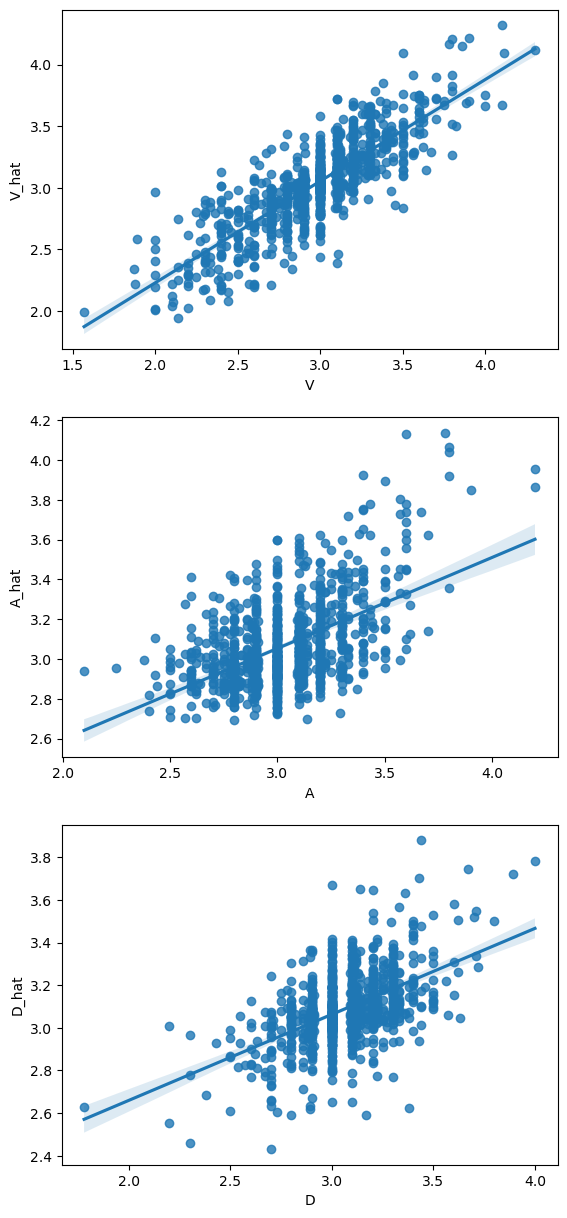

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(nrows=3)
fig.set_figheight(15)
sns.regplot(preds, x="V", y="V_hat", ax=axs[0])
sns.regplot(preds, x="A", y="A_hat", ax=axs[1])
sns.regplot(preds, x="D", y="D_hat", ax=axs[2])

In [59]:
def loop():
    fig, axs = plt.subplots(nrows=20, ncols=3)
    fig.set_figwidth(20)
    fig.set_figheight(100)

    for i in range(1, 21):
        c = get_checkpoint(i)
        model = AutoModelForSequenceClassification.from_pretrained(c)

        trainer = RegressionTrainer(
            model=model,
            args=training_args,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
        )
        predictions = trainer.predict(tokenized_dataset["test"])
        preds = pd.DataFrame(dataset["test"]).drop(["id", "split"], axis=1)[["text", "V", "A", "D"]]
        preds[["V_hat", "A_hat", "D_hat"]] = 4/(1+np.exp(-predictions[0])) + 1

        sns.regplot(preds, x="V", y="V_hat", ax=axs[i-1][0])
        sns.regplot(preds, x="A", y="A_hat", ax=axs[i-1][1])
        sns.regplot(preds, x="D", y="D_hat", ax=axs[i-1][2])



  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

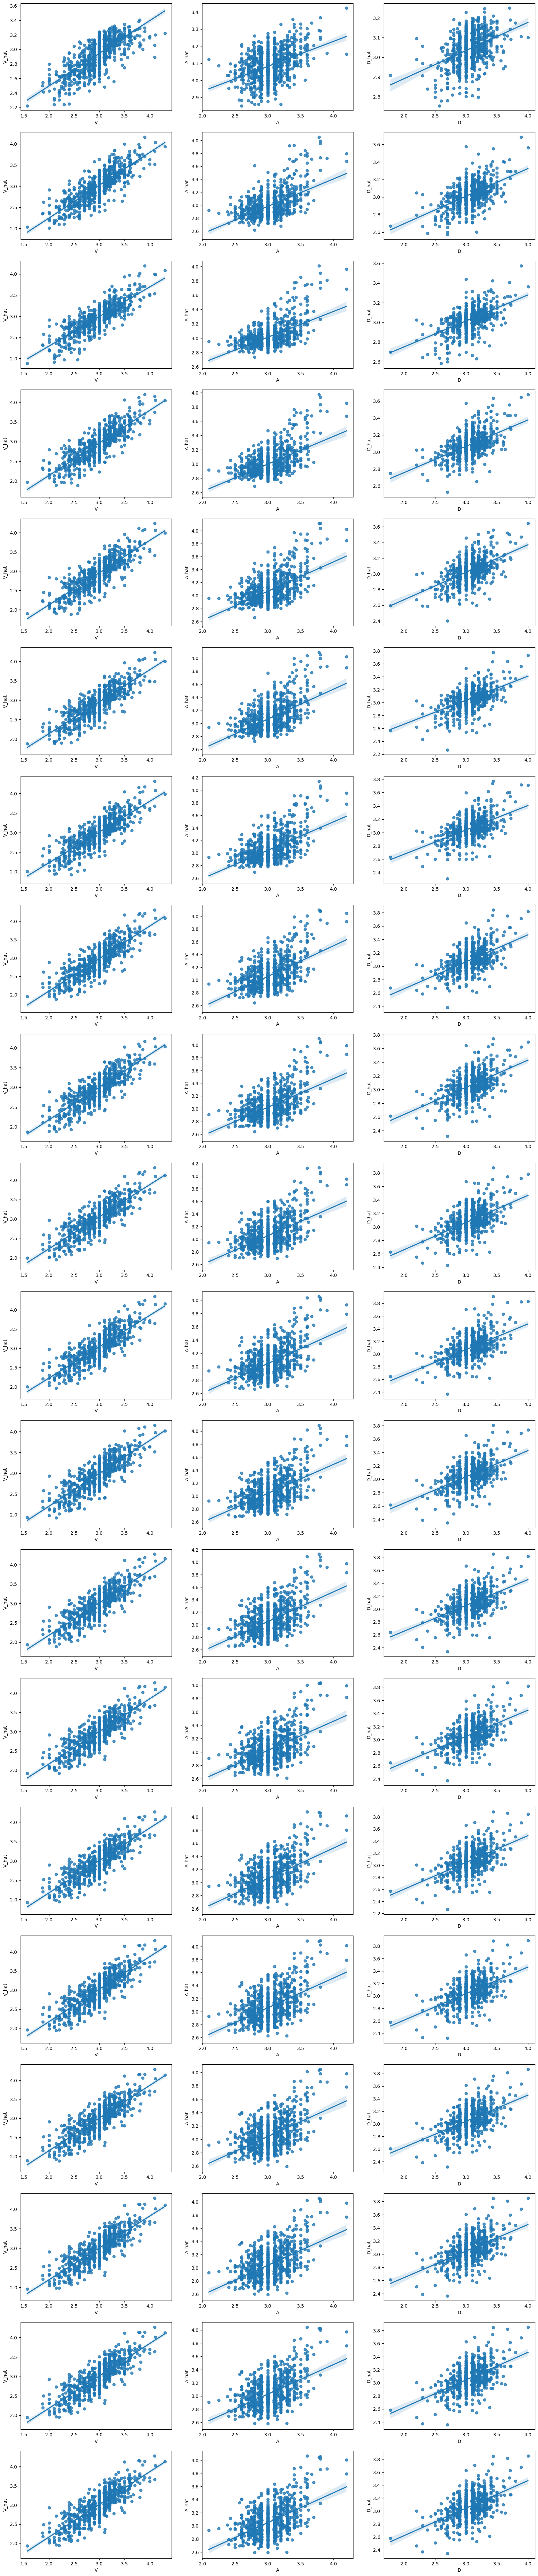

In [60]:
loop()